# Sesi 12 - Deep Dive ARIMA
## Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [ ]:
!pip install pmdarima

In [ ]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_beer = pd.read_csv('/content/drive/MyDrive/Indonesia AI DataSet/monthly-beer-production-in-austr.csv')
df_beer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9
...,...,...
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0


In [ ]:
df_beer['Month'] = pd.to_datetime(df_beer['Month'])
df_beer = df_beer.set_index('Month')
df_beer.index = pd.date_range(start=df_beer.index[0], periods=len(df_beer), freq='M') # Menunjukkan tanggal akhir setiap bulannya
df_beer

<ipython-input-71-4fde6367e4fa>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_beer.index = pd.date_range(start=df_beer.index[0], periods=len(df_beer), freq='M') # Menunjukkan tanggal akhir setiap bulannya


,Monthly beer production
1956-01-31,93.2
1956-02-29,96.0
1956-03-31,95.2
1956-04-30,77.1
1956-05-31,70.9
...,...
1995-04-30,127.0
1995-05-31,151.0
1995-06-30,130.0
1995-07-31,119.0


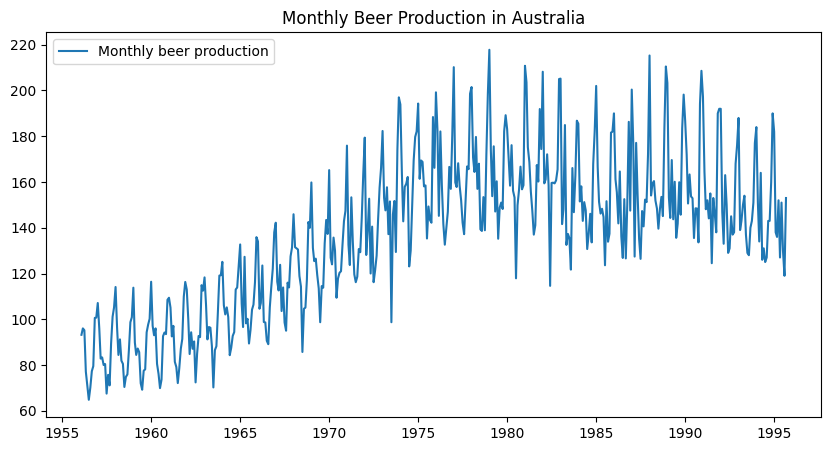

In [ ]:
# Lineplot untuk melihat tren data
plt.figure(figsize=(10,5))
plt.title('Monthly Beer Production in Australia')
sns.lineplot(data=df_beer)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

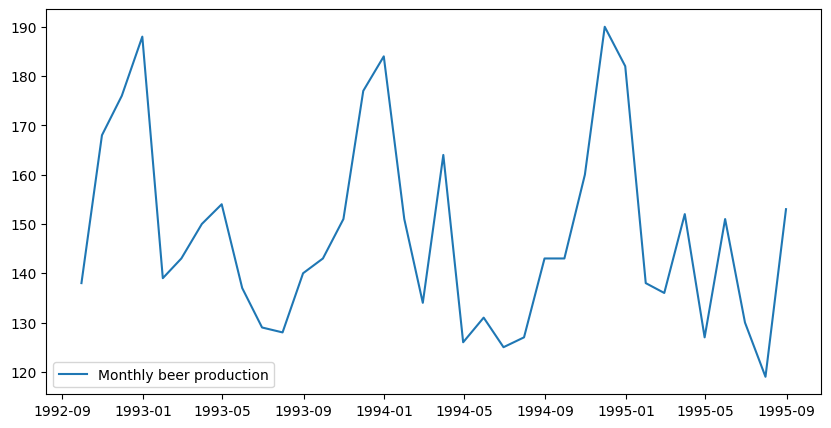

In [ ]:
plt.figure(figsize=(10,5))
# Detail timestamp
sns.lineplot(df_beer[-36:])
plt.show

In [ ]:
# Memunculkan 36 data terakhir
df_beer[-36:]

,Monthly beer production
1992-09-30,138.0
1992-10-31,168.0
1992-11-30,176.0
1992-12-31,188.0
1993-01-31,139.0
1993-02-28,143.0
1993-03-31,150.0
1993-04-30,154.0
1993-05-31,137.0
1993-06-30,129.0


Terlihat data yang digunakan memiliki tren dan musiman

<Figure size 1500x500 with 0 Axes>

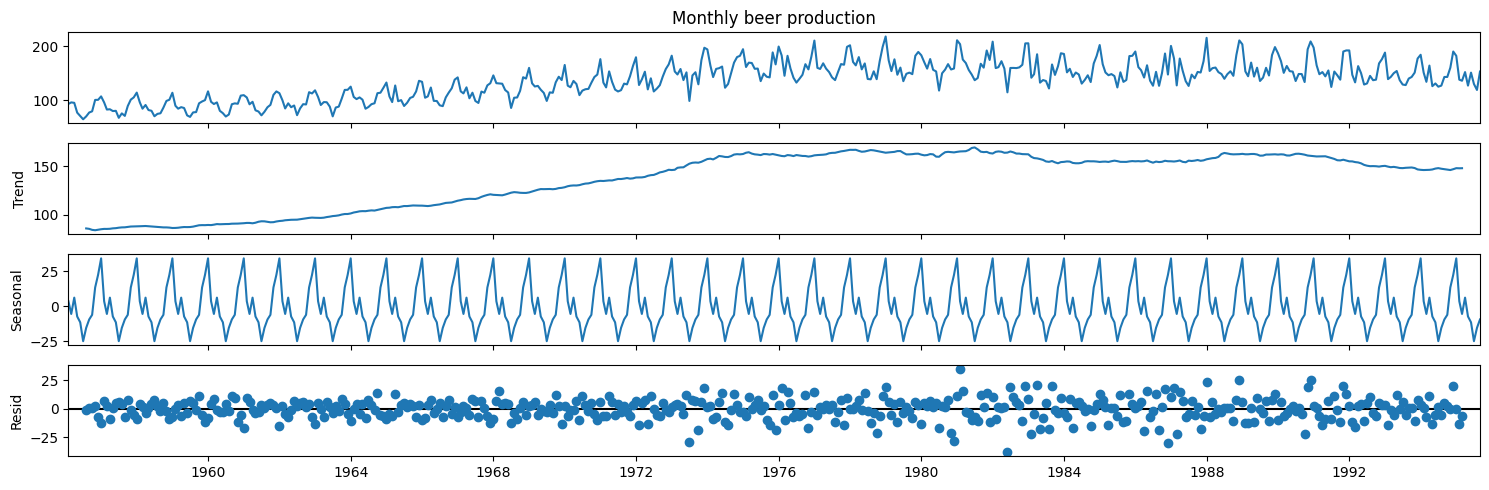

In [ ]:
# Decompose Time Series

# Make fig size bigger
plt.rcParams['figure.figsize'] = (15, 5)
# Decompose time series
decomposition = seasonal_decompose(df_beer['Monthly beer production'], model='add')
fig = plt.figure()
fig = decomposition.plot()


Selain model aditif, jika data deret waktu Anda tidak mengandung komponen musiman (seasonal), Anda bisa menggunakan model multiplicative atau model yang hanya mempertimbangkan trend dan residual

# EDA

## Menentukan I (Integrated) pada ARIMA, dan menentukan AR dan MA

### Menentukan I (Integrated)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_beer['Monthly beer production'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.282661
p-value: 0.177621


Nilai p-value lebih dari 0.05, yang berarti data adalah tidak stasioner

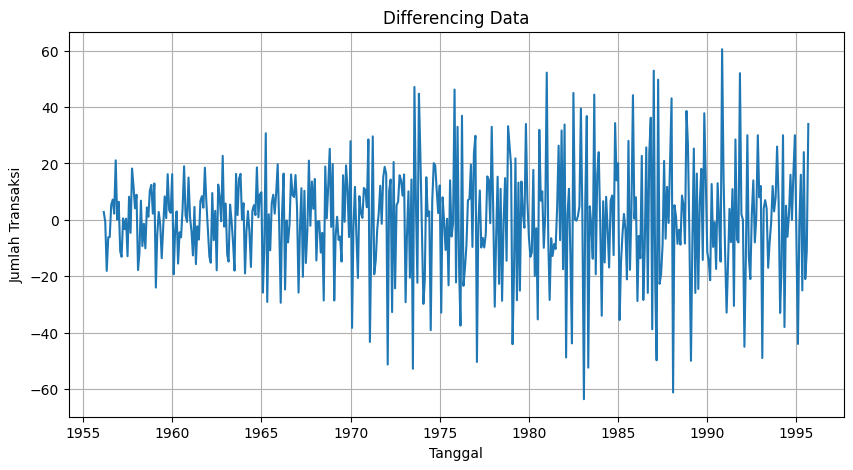

In [ ]:
# Plot nilai df_transactions['transactions'].diff().dropna() dengan d = 1
plt.figure(figsize=(10, 5))
plt.plot(df_beer['Monthly beer production'].diff().dropna())
plt.title('Differencing Data')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.grid(True)
plt.show()

In [ ]:
# Menggunakan d=1 untuk data non seasonal

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_beer['Monthly beer production'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.980664
p-value: 0.000024


In [ ]:
# Menggunakan D=1 untuk data yang mengandung pola musiman

from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_beer['Monthly beer production'].diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.861574
p-value: 0.000000


Nilai adf statistic lebih kecil dari sebelumnya, dan juga p-value < 0.05, yang berarti data adalah stasioner

### Menentukan AR dan MA

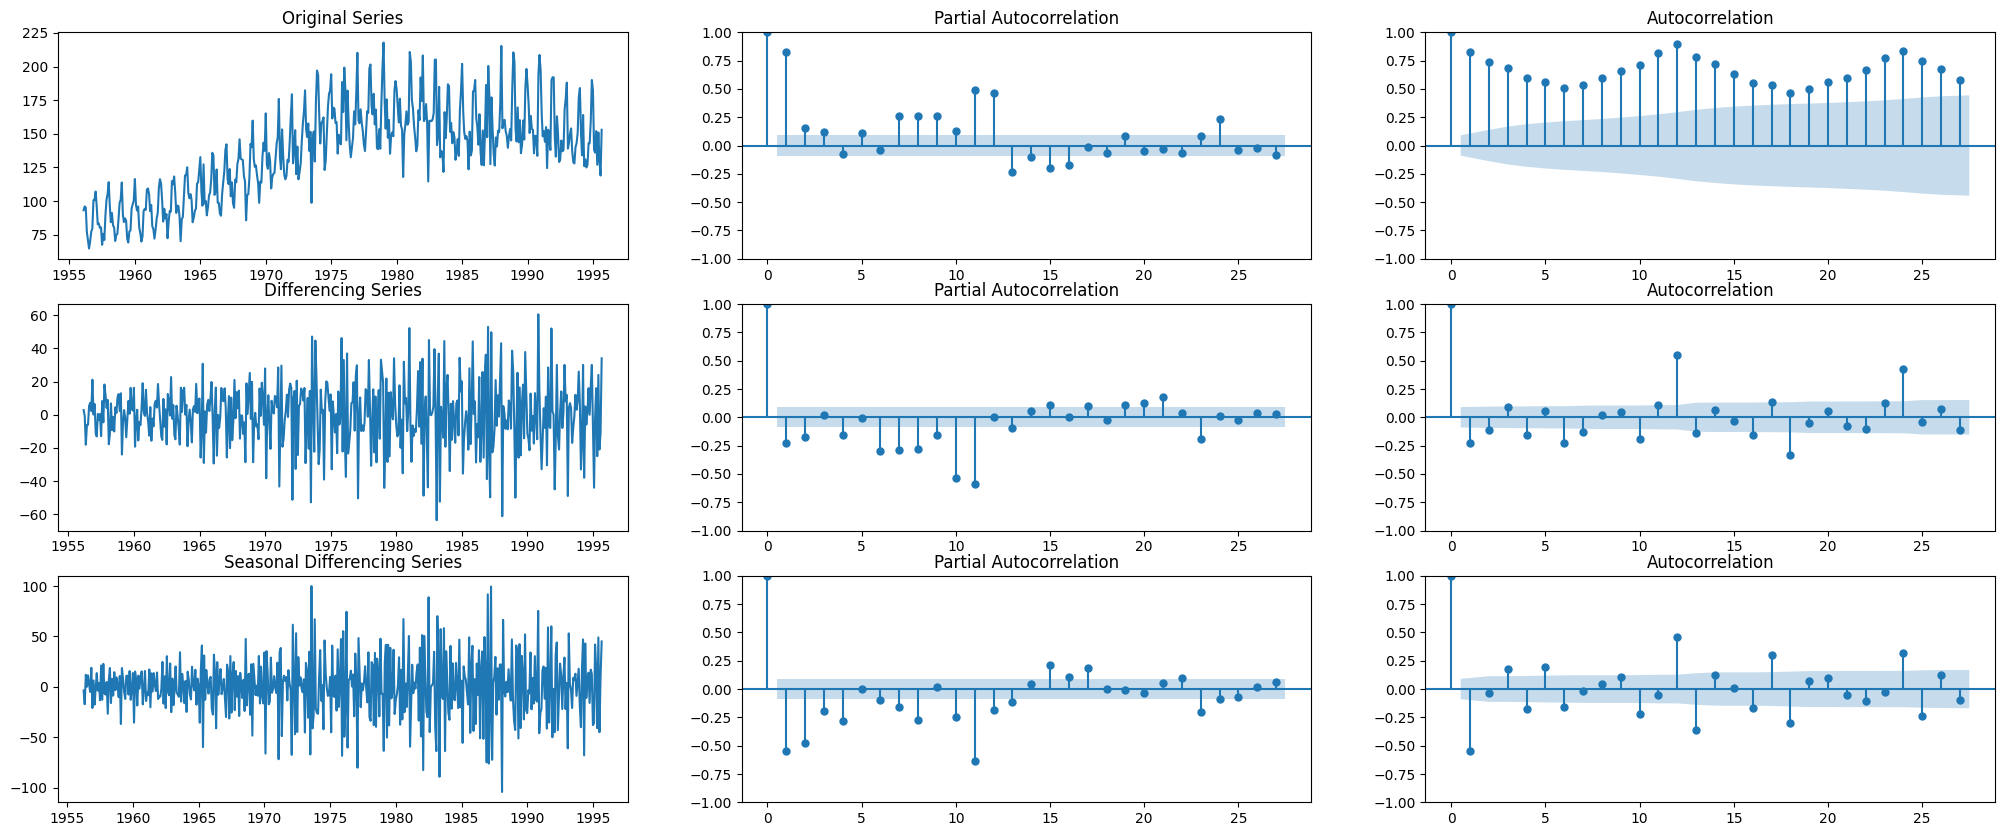

In [ ]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(3, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_beer['Monthly beer production'])
ax[0, 1] = plot_pacf(df_beer['Monthly beer production'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_beer['Monthly beer production'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_beer['Monthly beer production'].diff().dropna())
ax[1, 1] = plot_pacf(df_beer['Monthly beer production'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_beer['Monthly beer production'].diff().dropna(), ax=ax[1, 2])

ax[2, 0].set_title('Seasonal Differencing Series')
ax[2, 0].plot(df_beer['Monthly beer production'].diff().diff().dropna())
ax[2, 1] = plot_pacf(df_beer['Monthly beer production'].diff().diff().dropna(), ax=ax[2, 1])
ax[2, 2] = plot_acf(df_beer['Monthly beer production'].diff().diff().dropna(), ax=ax[2, 2])

plt.show()


Jika menggunakan I = 1, maka kita akan menggunakan AR yang memiliki spike di lag 1, dan MA di lag 1, sedangkan seasonal akan menggunakan 12, dan AR dan MA yang memiliki spike di lag 1 juga

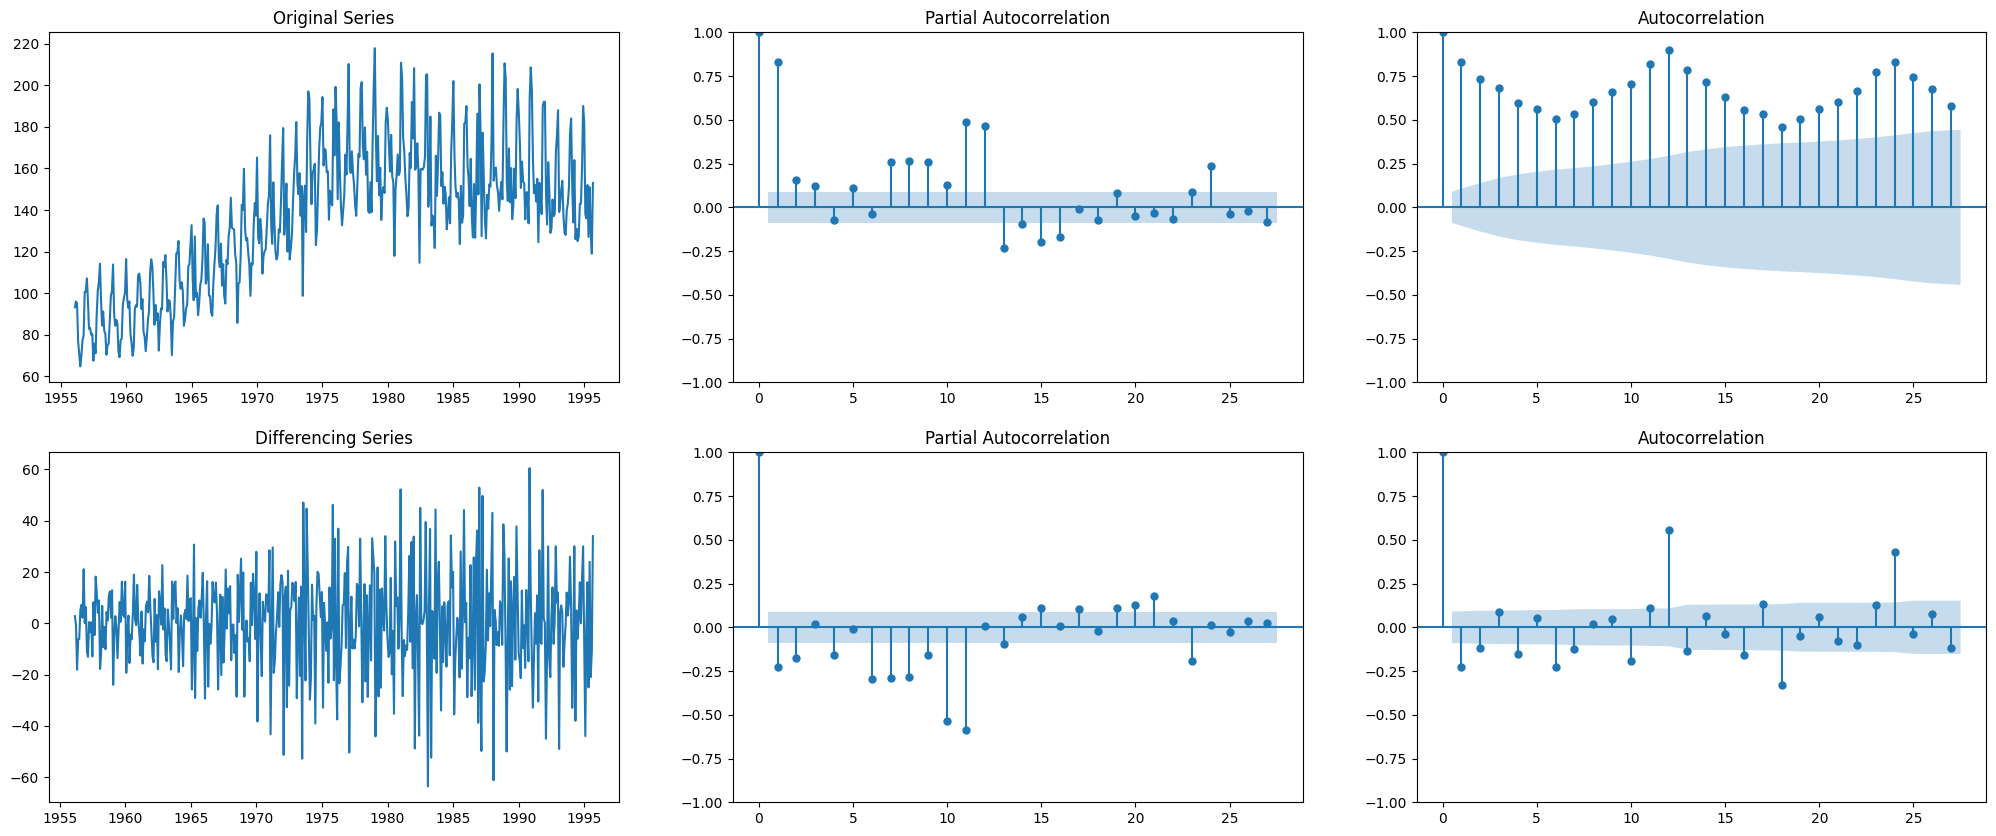

In [ ]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_beer['Monthly beer production'])
ax[0, 1] = plot_pacf(df_beer['Monthly beer production'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_beer['Monthly beer production'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_beer['Monthly beer production'].diff().dropna())
ax[1, 1] = plot_pacf(df_beer['Monthly beer production'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_beer['Monthly beer production'].diff().dropna(), ax=ax[1, 2])

plt.show()


# Modeling

## Out-of-Time Cross validation

In [ ]:
# Out-of-Time Cross validation
train = df_beer['Monthly beer production'][:len(df_beer)-60]
test = df_beer['Monthly beer production'][len(df_beer)-60:] # Menampilkan 60 data terakhir

In [ ]:
train

,Monthly beer production
1956-01-31,93.2
1956-02-29,96.0
1956-03-31,95.2
1956-04-30,77.1
1956-05-31,70.9
...,...
1990-04-30,153.7
1990-05-31,152.9
1990-06-30,135.5
1990-07-31,148.5


In [ ]:
test

,Monthly beer production
1990-09-30,133.6
1990-10-31,194.1
1990-11-30,208.6
1990-12-31,197.3
1991-01-31,164.4
1991-02-28,148.1
1991-03-31,152.0
1991-04-30,144.1
1991-05-31,155.0
1991-06-30,124.5


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Seasoaonal ARIMA Model
# SARIMA = (p,d,q)(P,D,Q)S
model = ARIMA(train, order=(11,1,2), seasonal_order=(3,1,1,12))
model_fit_cross = model.fit()
print(model_fit_cross.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:             Monthly beer production   No. Observations:                  416
Model:             ARIMA(11, 1, 2)x(3, 1, [1], 12)   Log Likelihood               -1467.994
Date:                             Fri, 17 Jan 2025   AIC                           2971.987
Time:                                     12:35:45   BIC                           3043.968
Sample:                                 01-31-1956   HQIC                          3000.484
                                      - 08-31-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0783      0.970     -0.081      0.936      -1.979       1.822
ar.L2         -0.2707      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


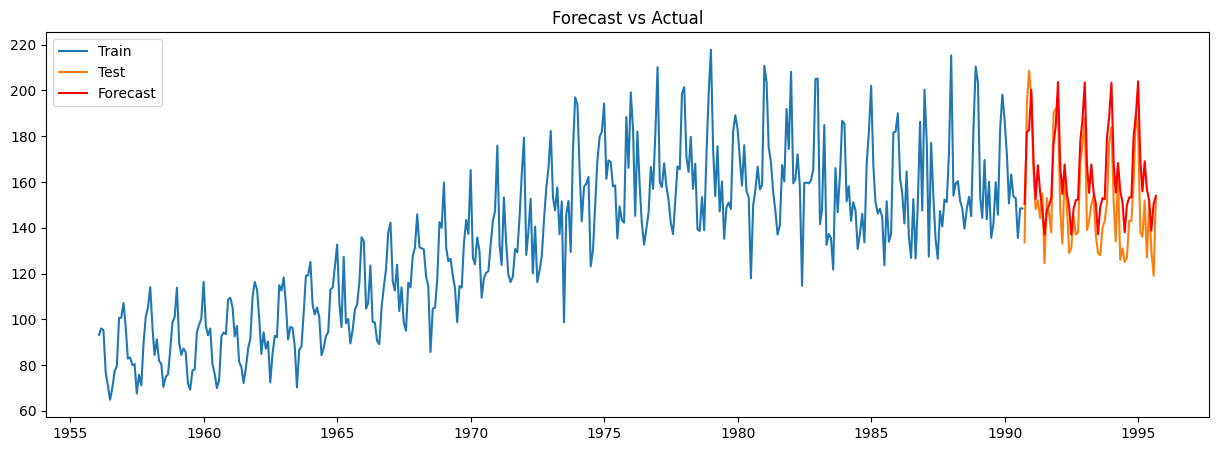

In [ ]:
# Prediction
forecast = model_fit_cross.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

## ARIMA Modeling

### ARIMA (p,d,q)

In [ ]:
# 1,0,1 ARIMA Model
model = ARIMA(df_beer['Monthly beer production'], order=(11,1,2))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                  SARIMAX Results                                  
Dep. Variable:     Monthly beer production   No. Observations:                  476
Model:                     ARIMA(11, 1, 2)   Log Likelihood               -1800.203
Date:                     Fri, 17 Jan 2025   AIC                           3628.406
Time:                             12:35:56   BIC                           3686.692
Sample:                         01-31-1956   HQIC                          3651.327
                              - 08-31-1995                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9581      0.063    -15.303      0.000      -1.081      -0.835
ar.L2         -0.8692      0.048    -17.970      0.000      -0.964      -0.774
ar.L3       

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### SARIMA (p,d,q)(P,D,Q,s)

In [ ]:
# Seasoaonal ARIMA Model
model1 = ARIMA(df_beer['Monthly beer production'], order=(11,1,2), seasonal_order=(1,1,1,12))
model_fit1 = model1.fit()
print(model_fit1.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:             Monthly beer production   No. Observations:                  476
Model:             ARIMA(11, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1685.598
Date:                             Fri, 17 Jan 2025   AIC                           3403.197
Time:                                     12:36:38   BIC                           3469.400
Sample:                                 01-31-1956   HQIC                          3429.259
                                      - 08-31-1995                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0544      0.665     -0.082      0.935      -1.358       1.249
ar.L2         -0.3503      

### Auto ARIMA

In [ ]:
model = pm.auto_arima(train,
                      start_p=11,        # nilai p pertama
                      start_q=2,        # nilai q pertama
                      test='adf',       # gunakan adftest untuk mencari optimal 'd'
                      max_p=11,          # maksimal p
                      max_q=2,          # maksimal q
                      d=1,           # let model determine 'd'
                      m=12,             # frequency of series
                      seasonal=True,    # Seasonality
                      start_P=1,        # nilai P pertama
                      D=1,           # let model determine 'D'
                      start_Q=1,        # nilai Q pertama
                      max_P=11,          # maksimal P
                      max_D=1,          # maksimal D
                      max_Q=1,          # maksimal Q
                      trace=True,       # print result
                      error_action='ignore',    # we don't want to know if an order does not work
                      suppress_warnings=True,   # we don't want convergence warnings
                      stepwise=True)        # set to stepwise

print(model.summary())

Performing stepwise search to minimize aic


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,2)(1,1,1)[12]             : AIC=2969.346, Time=12.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3508.570, Time=0.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3340.532, Time=0.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3033.294, Time=1.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,2)(0,1,1)[12]             : AIC=2968.310, Time=6.02 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,2)(0,1,0)[12]             : AIC=3088.800, Time=2.59 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,2)(1,1,0)[12]             : AIC=3040.727, Time=10.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(0,1,1)[12]             : AIC=2966.115, Time=8.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(0,1,0)[12]             : AIC=inf, Time=8.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(1,1,1)[12]             : AIC=2961.028, Time=18.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(1,1,0)[12]             : AIC=3038.817, Time=10.17 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(2,1,1)[12]             : AIC=2962.228, Time=36.25 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(2,1,0)[12]             : AIC=3010.544, Time=15.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,2)(1,1,1)[12]             : AIC=2974.473, Time=14.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,1)(1,1,1)[12]             : AIC=2965.560, Time=19.13 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(9,1,1)(1,1,1)[12]             : AIC=2976.454, Time=11.23 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(11,1,1)(1,1,1)[12]             : AIC=2967.306, Time=17.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(10,1,2)(1,1,1)[12] intercept   : AIC=2964.366, Time=17.89 sec

Best model:  ARIMA(10,1,2)(1,1,1)[12]          
Total fit time: 211.743 seconds
                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                  416
Model:             SARIMAX(10, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1465.514
Date:                               Fri, 17 Jan 2025   AIC                           2961.028
Time:                                       12:40:09   BIC                           3021.012
Sample:                                   01-31-1956   HQIC                          2984.775
                                        - 08-31-1990                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Stepwise adalah algoritma yang secara bertahap menambahkan atau menghapus parameter dari model ARIMA berdasarkan kriteria informasi seperti AIC (Akaike Information Criterion) atau BIC (Bayesian Information Criterion). Tujuannya adalah untuk menemukan kombinasi parameter yang meminimalkan nilai kriteria informasi tersebut

In [ ]:
# Seasoaonal ARIMA Model
model = ARIMA(train, order=(10,1,2), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:             Monthly beer production   No. Observations:                  416
Model:             ARIMA(10, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1465.514
Date:                             Fri, 17 Jan 2025   AIC                           2961.028
Time:                                     12:40:30   BIC                           3021.012
Sample:                                 01-31-1956   HQIC                          2984.775
                                      - 08-31-1990                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2938      0.120    -10.746      0.000      -1.530      -1.058
ar.L2         -2.0144      

# Uji Diagnostik

## Residuals

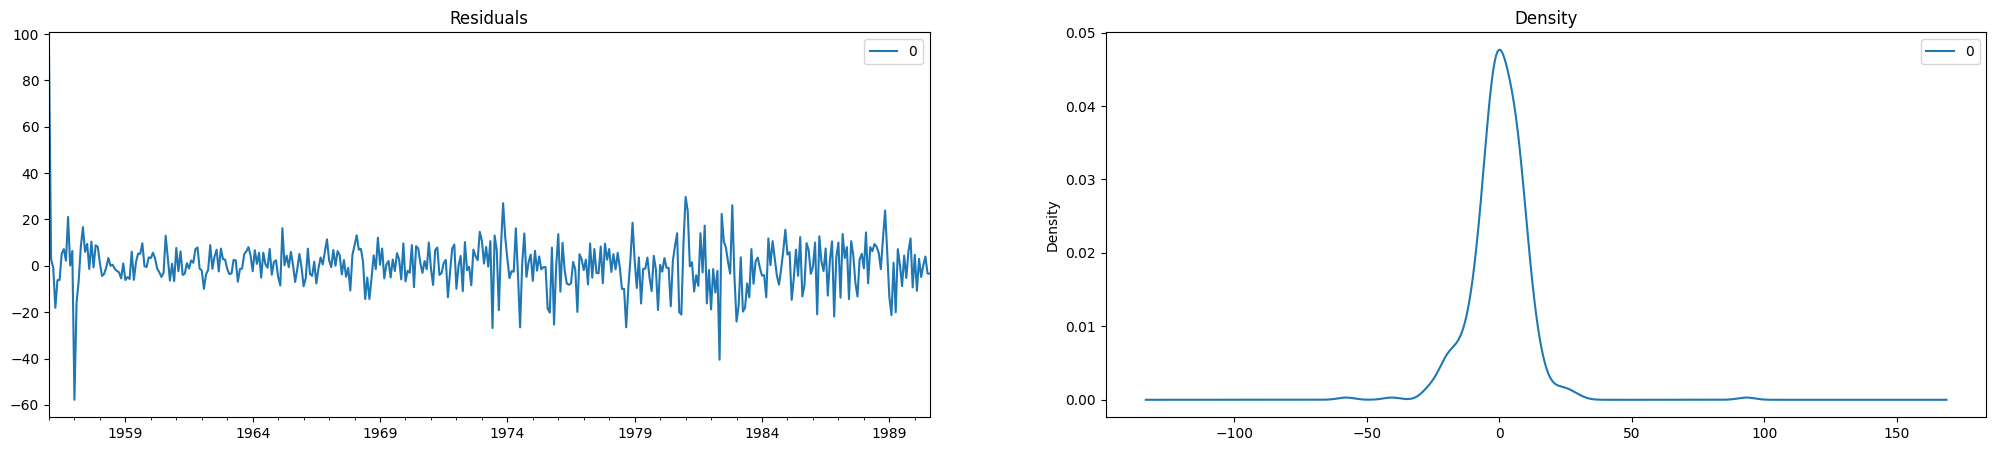

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Ploting Prediksi

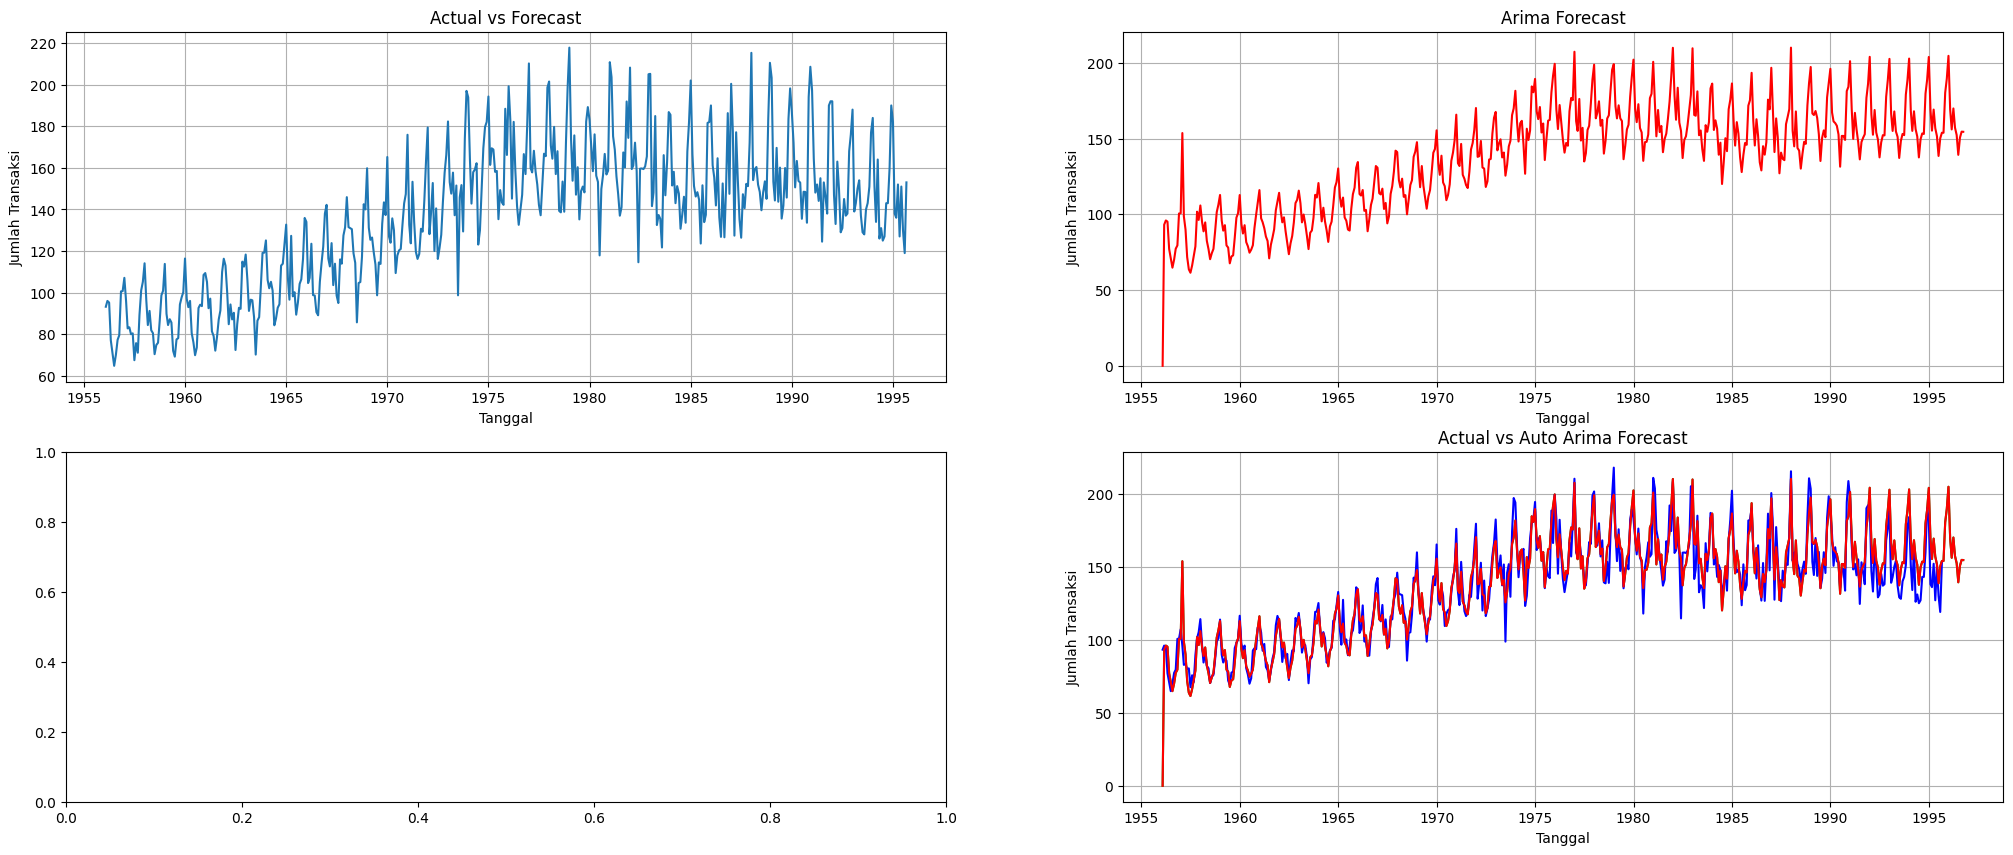

In [ ]:
# Predict data
start_index = 0
end_index = len(df_beer)+12
# Forecast
forecast = model_fit.predict(start=start_index, end=end_index)
# Actual
actual = df_beer['Monthly beer production']

# Plot actual vs forecast
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0,0].plot(actual)
ax[0,0].set_title('Actual vs Forecast')
ax[0,0].set_xlabel('Tanggal')
ax[0,0].set_ylabel('Jumlah Transaksi')
ax[0,0].grid(True)

ax[0,1].plot(forecast, color='red')
ax[0,1].set_title('Arima Forecast')
ax[0,1].set_xlabel('Tanggal')
ax[0,1].set_ylabel('Jumlah Transaksi')
ax[0,1].grid(True)


ax[1,1].plot(forecast, color='green')
ax[1,1].plot(actual, color='blue')
ax[1,1].plot(forecast, color='red')
ax[1,1].set_title('Actual vs Auto Arima Forecast')
ax[1,1].set_xlabel('Tanggal')
ax[1,1].set_ylabel('Jumlah Transaksi')
ax[1,1].grid(True)


In [ ]:
forecast

,predicted_mean
1956-01-31,0.000000
1956-02-29,93.191558
1956-03-31,95.997539
1956-04-30,95.203766
1956-05-31,77.099568
...,...
1996-05-31,152.391567
1996-06-30,139.316739
1996-07-31,150.655672
1996-08-31,154.632899


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


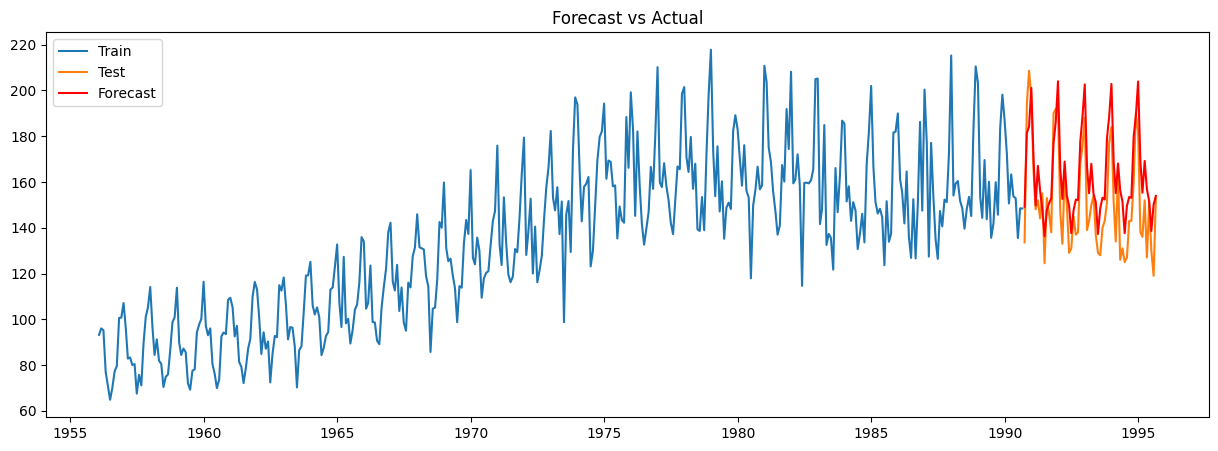

In [ ]:
# Prediction
forecast = model_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

# Integrasi Model

## Ensembling Method ARIMA

In [ ]:
# Ensembling
# Train multiple ARIMA models
models = []
for order in [(1,0,0), (0,1,0), (1,1,0)]:
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    models.append(model_fit)

# Combine predictions using ensemble method (e.g., averaging)
predictions = [model.predict(start=len(train), end=len(train) + len(test)-1) for model in models]
ensemble_forecast = sum(predictions) / len(predictions)

In [ ]:
ensemble_forecast

,predicted_mean
1990-09-30,147.654834
1990-10-31,147.016451
1990-11-30,146.479539
1990-12-31,146.025526
1991-01-31,145.642221
1991-02-28,145.318460
1991-03-31,145.045032
1991-04-30,144.814103
1991-05-31,144.619068
1991-06-30,144.454349


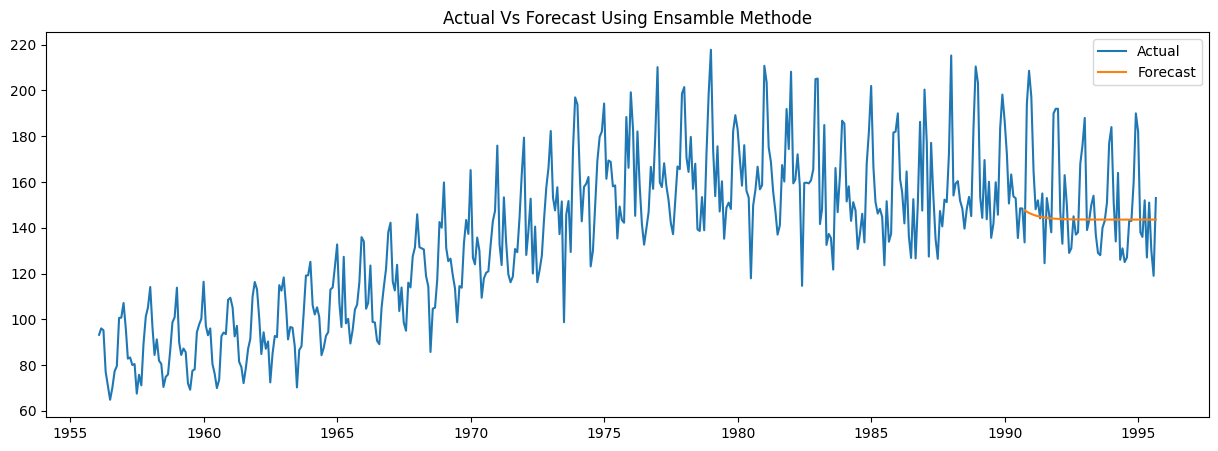

In [ ]:
# Actual
actual = df_beer['Monthly beer production']

plt.figure(figsize=(15,5))
plt.title('Actual Vs Forecast Using Ensamble Methode')
plt.plot(actual, label='Actual')
plt.plot(ensemble_forecast, label='Forecast')
plt.legend()

## Integrasi dengan Teknik Lain

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train ARIMA model
arima_model = ARIMA(train, order=(1,1,1))
arima_model_fit = arima_model.fit()

# Train Exponential Smoothing model
es_model = ExponentialSmoothing(train)
es_model_fit = es_model.fit()

# Combine predictions from ARIMA and Exponential Smoothing
arima_forecast = arima_model_fit.forecast(steps=len(test))
es_forecast = es_model_fit.forecast(steps=len(test))
combined_forecast = (arima_forecast + es_forecast) / 2

In [ ]:
combined_forecast

,0
1990-09-30,150.544936
1990-10-31,151.746855
1990-11-30,152.324413
1990-12-31,152.601947
1991-01-31,152.735311
1991-02-28,152.799396
1991-03-31,152.830191
1991-04-30,152.844989
1991-05-31,152.852099
1991-06-30,152.855516


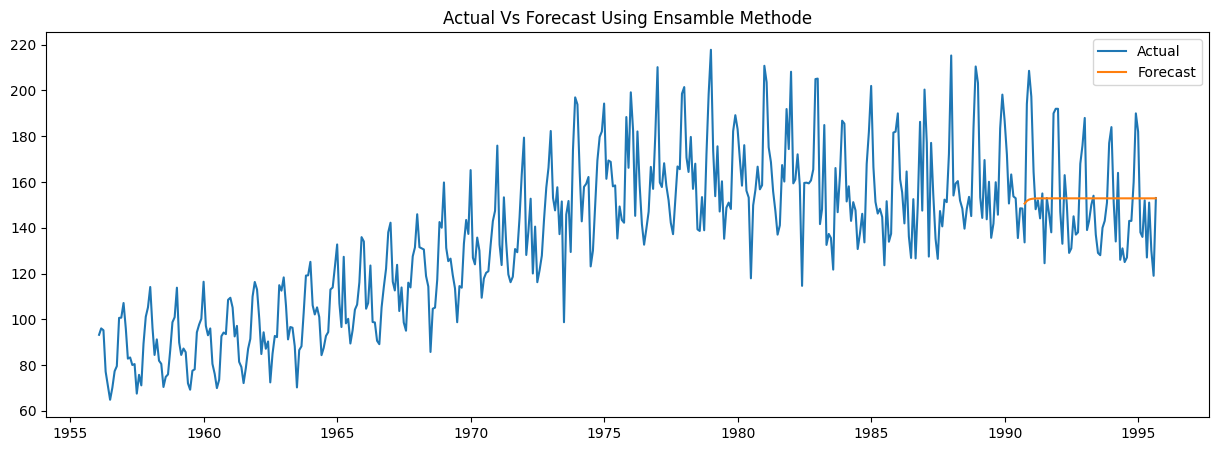

In [ ]:
# Actual
actual = df_beer['Monthly beer production']

plt.figure(figsize=(15,5))
plt.title('Actual Vs Forecast Using Ensamble Methode')
plt.plot(actual, label='Actual')
plt.plot(combined_forecast, label='Forecast')
plt.legend()